In [0]:
# Colab requires downgrading to Tf v1
!pip install --upgrade tensorflow==1.14.0

## MNIST using Convolutional Neural Network built in Tensorflow

### Loading Data, Defining Placeholders and Util functions

In [0]:
import tensorflow as tf
import pandas as pd

df = pd.read_csv("sample_data/mnist_train_small.csv")
df.head(5)

In [3]:
train_data = df.values
print(train_data.shape)

(19999, 785)


In [4]:
x_train_data = train_data[:,1:]
labels = train_data[:,0]

print(x_train_data.shape, labels.shape)

(19999, 784) (19999,)


In [5]:
import numpy as np
def one_hot_encoding(correct_class, number_of_classes):
    li = [0]*number_of_classes
    li[correct_class]=1
    return np.array(li)

one_hot_encoding(1, 10)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
y_train_data = []
for label in labels:
    y_train_data += [one_hot_encoding(label, 10)]

y_train_data = np.array(y_train_data)
print(y_train_data.shape)
print(y_train_data[:5])

(19999, 10)
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


In [7]:
df_test = pd.read_csv("sample_data/mnist_test.csv")
print(df_test.head(5))

   7  0  0.1  0.2  0.3  0.4  ...  0.662  0.663  0.664  0.665  0.666  0.667
0  2  0    0    0    0    0  ...      0      0      0      0      0      0
1  1  0    0    0    0    0  ...      0      0      0      0      0      0
2  0  0    0    0    0    0  ...      0      0      0      0      0      0
3  4  0    0    0    0    0  ...      0      0      0      0      0      0
4  1  0    0    0    0    0  ...      0      0      0      0      0      0

[5 rows x 785 columns]


In [8]:
test_data = df_test.values
print(test_data.shape)

x_test_data = test_data[:,1:]
test_labels = test_data[:,0]

print(x_test_data.shape, test_labels.shape)

(9999, 785)
(9999, 784) (9999,)


In [9]:
y_test_data = []
for label in test_labels:
    y_test_data += [one_hot_encoding(label, 10)]

y_test_data = np.array(y_test_data)
print(y_test_data.shape)
print(y_test_data[:5])

(9999, 10)
[[0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]


In [0]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1, 28, 28, 1])

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [0]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

### Designing CNN Architecture

In [0]:
# Defining 1st conv layer

W_conv1 = weight_variable([5,5,1,32]) # 32 filters of 5x5 size
bias_conv1 = bias_variable([32])      #  1 bias for each filer

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + bias_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [0]:
# Defining 2nd conv layer

W_conv2 = weight_variable([5,5, 32, 64]) # 64 filters of 32x32 size
bias_conv2 = bias_variable([64])      #  1 bias for each filer

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + bias_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [0]:
# Fully Connected Layer

# Flattening the output from Conv Layers
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

# Defining weights for FC layer
W_fc1 = weight_variable([7*7*64, 1024])
bias_fc1 = bias_variable([1024]) 

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + bias_fc1)

In [16]:
# Dropout

keep_prob = tf.placeholder(tf.float32)
h_fc1_dropout = tf.nn.dropout(h_fc1, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Defining weights for last FC layer

W_fc2 = weight_variable([1024, 10])
bias_fc2 = bias_variable([10]) 

y_conv = tf.matmul(h_fc1_dropout, W_fc2) + bias_fc2

In [18]:
# Calculating Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# Defining Optimiser
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# Correct pred
correct_predictions = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [20]:
# Initialise

sess.run(tf.global_variables_initializer())
 
import time
num_steps = 3000
display_every = 100
history = []

start_time = time.time()

i = 0
for step in range(num_steps):
    if i > x_train_data.shape[0]-50: i=0
    train_step.run(feed_dict = {x: x_train_data[i:i+50], y_: y_train_data[i:i+50], keep_prob:0.5})
    i+=50

    train_accuracy = accuracy.eval(feed_dict = {x: x_train_data[i:i+50], y_: y_train_data[i:i+50], keep_prob:0.5})
    history += [train_accuracy*100]

    if step%display_every == 0:
        end_time = time.time()
        print("step: {} time elapsed: {} accuracy: {}".format(step, end_time - start_time, train_accuracy))


print("\n---------Training Finished----------------\n\nTrain Stats:")

i = np.random.randint(1, 1000)
train_accuracy = accuracy.eval(feed_dict = {x: x_train_data[i:i+100], y_: y_train_data[i:i+100], keep_prob:1})
end_time = time.time()
print("time elapsed: {} accuracy: {}".format(end_time - start_time, train_accuracy*100))

step: 0 time elapsed: 0.26169419288635254 accuracy: 0.07999999821186066
step: 100 time elapsed: 20.852881908416748 accuracy: 0.6200000047683716
step: 200 time elapsed: 41.36643600463867 accuracy: 0.800000011920929
step: 300 time elapsed: 61.94498562812805 accuracy: 0.7599999904632568
step: 400 time elapsed: 82.63988947868347 accuracy: 0.8399999737739563
step: 500 time elapsed: 103.24352049827576 accuracy: 0.9200000166893005
step: 600 time elapsed: 124.02728915214539 accuracy: 0.9399999976158142
step: 700 time elapsed: 144.47335958480835 accuracy: 0.8399999737739563
step: 800 time elapsed: 165.01385235786438 accuracy: 0.8999999761581421
step: 900 time elapsed: 185.5901381969452 accuracy: 0.8199999928474426
step: 1000 time elapsed: 206.06677913665771 accuracy: 0.9399999976158142
step: 1100 time elapsed: 226.78124713897705 accuracy: 0.9200000166893005
step: 1200 time elapsed: 247.367369890213 accuracy: 0.9200000166893005
step: 1300 time elapsed: 267.90918588638306 accuracy: 0.920000016689

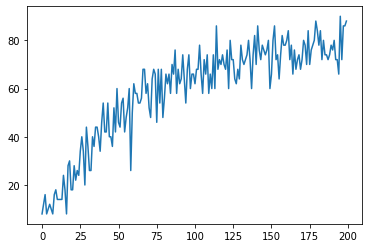

In [21]:
from matplotlib import pyplot as plt


plt.x_label="Accuracy"
plt.y_label="Epochs"
plt.title = "Training Graph"
plt.plot(list(range(len(history))), history)

In [22]:
print("\n---------Test Results----------------\n")

start_time = time.time()
test_accuracy = accuracy.eval(feed_dict = {x: x_test_data, y_: y_test_data, keep_prob:0.5})
end_time = time.time()
print("time elapsed: {}sec \naccuracy: {}".format(end_time - start_time, test_accuracy))


---------Test Results----------------

time elapsed: 8.081157684326172sec 
accuracy: 0.9315931797027588
